## Import The Libraries

In [1]:
!pip install tensorflow==2.17.0 numpy==1.26.4 pandas==2.2.2 scikit-learn==1.5.1 matplotlib==3.9.2 scipy==1.13.1

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam

In [27]:
## ---- Load and preprocess ---- ##
df = pd.read_csv("10000 stock price data.csv")
df.shape #check the shape

(11601, 14)

In [5]:
df.columns

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')

## LSTM for Each symbol

In [28]:
## MUNDRAPORT
symbol = 'MUNDRAPORT'
df_symbol = df[df['Symbol'] == symbol].copy()
if 'Date' in df_symbol.columns:
    df_symbol.sort_values('Date', inplace=True)
    df_symbol.set_index('Date', inplace=True)
else:
    df_symbol.sort_index(inplace=True)

In [29]:
train_size = int(len(df_symbol) * 0.8)
train = df_symbol['Close'][:train_size]
test = df_symbol['Close'][train_size:]

In [30]:
# Prepare data for LSTM
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_symbol['Close'].values.reshape(-1, 1))

In [31]:
# Create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

In [32]:
# Split sequences into train and test
train_size_seq = int(len(X) * 0.8)
X_train, y_train = X[:train_size_seq], y[:train_size_seq]
X_test, y_test = X[train_size_seq:], y[train_size_seq:]

In [33]:
# Build LSTM model
model_1 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])
model_1.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [34]:
history = model_1.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0655 - val_loss: 0.0452
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0511 - val_loss: 0.0453
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0521 - val_loss: 0.0448
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0507 - val_loss: 0.0450
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0479 - val_loss: 0.0455
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0504 - val_loss: 0.0448
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0494 - val_loss: 0.0441
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0486 - val_loss: 0.0453
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0519 - val_loss: 0.0443
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0498 - val_loss: 0.0444
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0501 - val_loss: 0.0435
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0

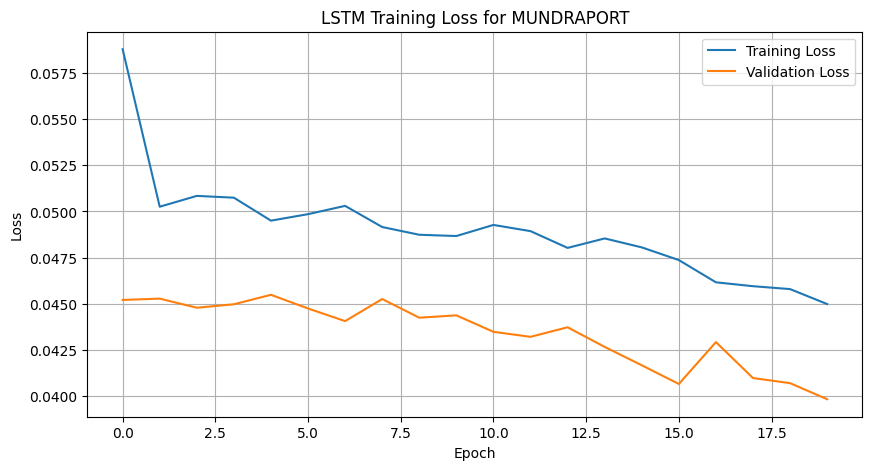

In [35]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'LSTM Training Loss for {symbol}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [56]:
# Forecast
predictions = model_1.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scale to original values
y_test = scaler.inverse_transform(y_test)  # Inverse scale test data

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [57]:
# Adjust for sequence length
forecast_df = pd.DataFrame({
        'Forecast': predictions.flatten(),
        'Actual': y_test.flatten()
})  # Align index with predictions

In [58]:
forecast_df.head()

,Forecast,Actual
0,301.398102,182.85
1,324.252930,340.75
2,288.738129,379.90
3,262.568787,116.70
4,333.164124,145.00


In [59]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'LSTM RMSE for {symbol}: {rmse}')

LSTM RMSE for ADANIPORTS: 127.24950182225746


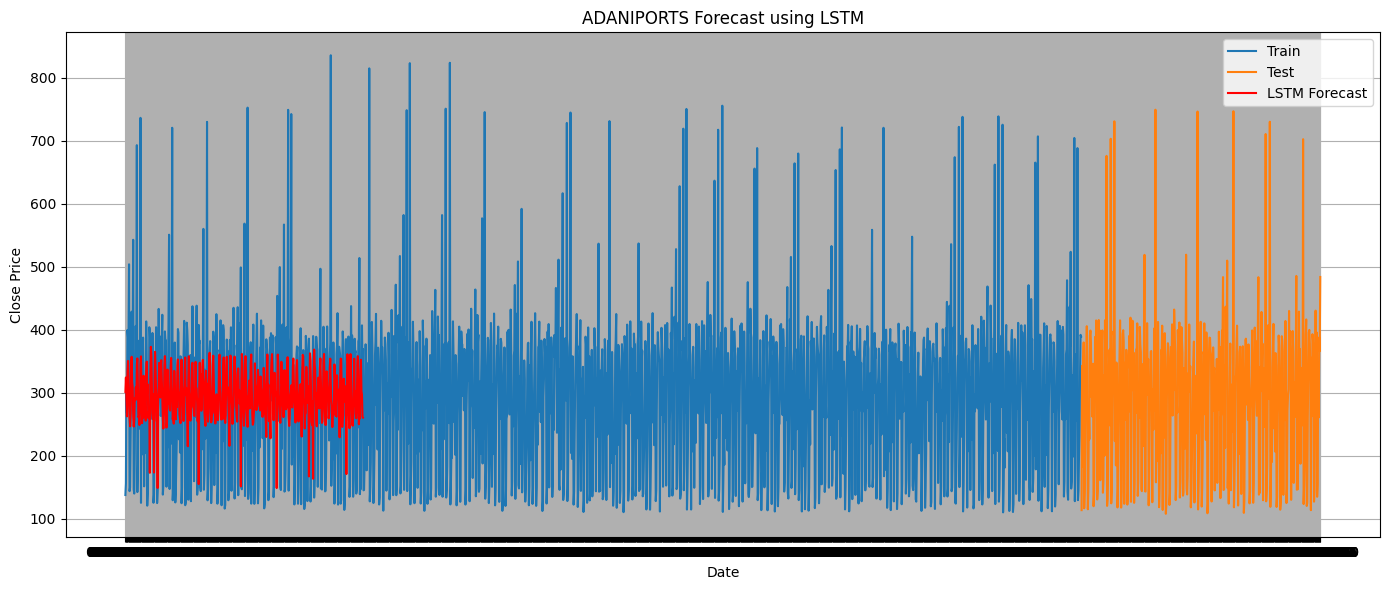

In [60]:
# Plot results
plt.figure(figsize=(14, 6))
plt.plot(df_symbol.index[:train_size], scaler.inverse_transform(scaled_data[:train_size]), label='Train')
plt.plot(df_symbol.index[train_size:], scaler.inverse_transform(scaled_data[train_size:]), label='Test')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='LSTM Forecast', color='red')
plt.title(f'{symbol} Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [45]:
## ADANIPORTS
symbol = 'ADANIPORTS'
df_symbol = df[df['Symbol'] == symbol].copy()
if 'Date' in df_symbol.columns:
    df_symbol.sort_values('Date', inplace=True)
    df_symbol.set_index('Date', inplace=True)
else:
    df_symbol.sort_index(inplace=True)

In [46]:
train_size = int(len(df_symbol) * 0.8)
train = df_symbol['Close'][:train_size]
test = df_symbol['Close'][train_size:]

In [47]:
# Prepare data for LSTM
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_symbol['Close'].values.reshape(-1, 1))

In [48]:
# Create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

In [49]:
# Split sequences into train and test
train_size_seq = int(len(X) * 0.8)
X_train, y_train = X[:train_size_seq], y[:train_size_seq]
X_test, y_test = X[train_size_seq:], y[train_size_seq:]

In [50]:
# Build LSTM model
model_2 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])
model_2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [51]:
history = model_2.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0442 - val_loss: 0.0323
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0294 - val_loss: 0.0316
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0273 - val_loss: 0.0311
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0283 - val_loss: 0.0301
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0248 - val_loss: 0.0290
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0257 - val_loss: 0.0284
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0227 - val_loss: 0.0268
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0243 - val_loss: 0.0265
Epoch 9/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0238 - val_loss: 0.0268
Epoch 10/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0245 - val_loss: 0.0249
Epoch 11/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0196 - val_loss: 0.0246
Epoch 12/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

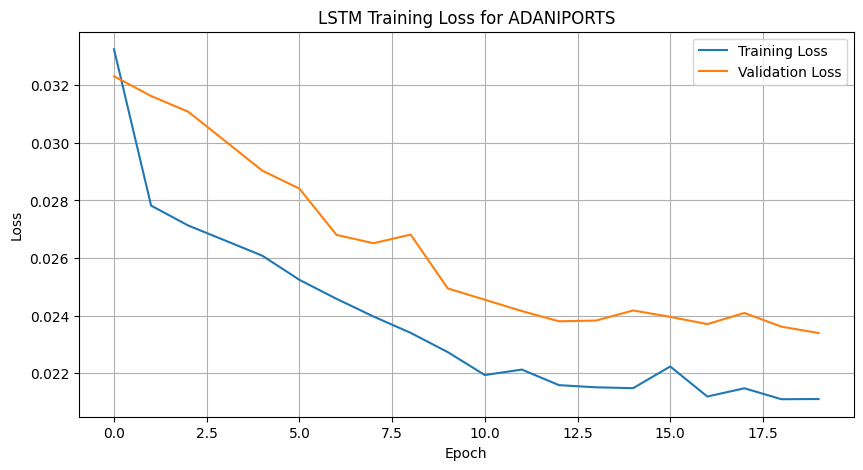

In [52]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'LSTM Training Loss for {symbol}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [61]:
# Forecast
predictions = model_2.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scale to original values
y_test = scaler.inverse_transform(y_test)  # Inverse scale test data

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


In [62]:
# Adjust for sequence length
forecast_df = pd.DataFrame({
        'Forecast': predictions.flatten(),
        'Actual': y_test.flatten()
})  # Align index with predictions

In [63]:
forecast_df.head()

,Forecast,Actual
0,239.353210,133140.5175
1,311.352844,248020.6625
2,343.338562,276504.2450
3,340.709045,85013.0850
4,310.866302,105602.7500


In [64]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'LSTM RMSE for {symbol}: {rmse}')

LSTM RMSE for ADANIPORTS: 228506.94090112197


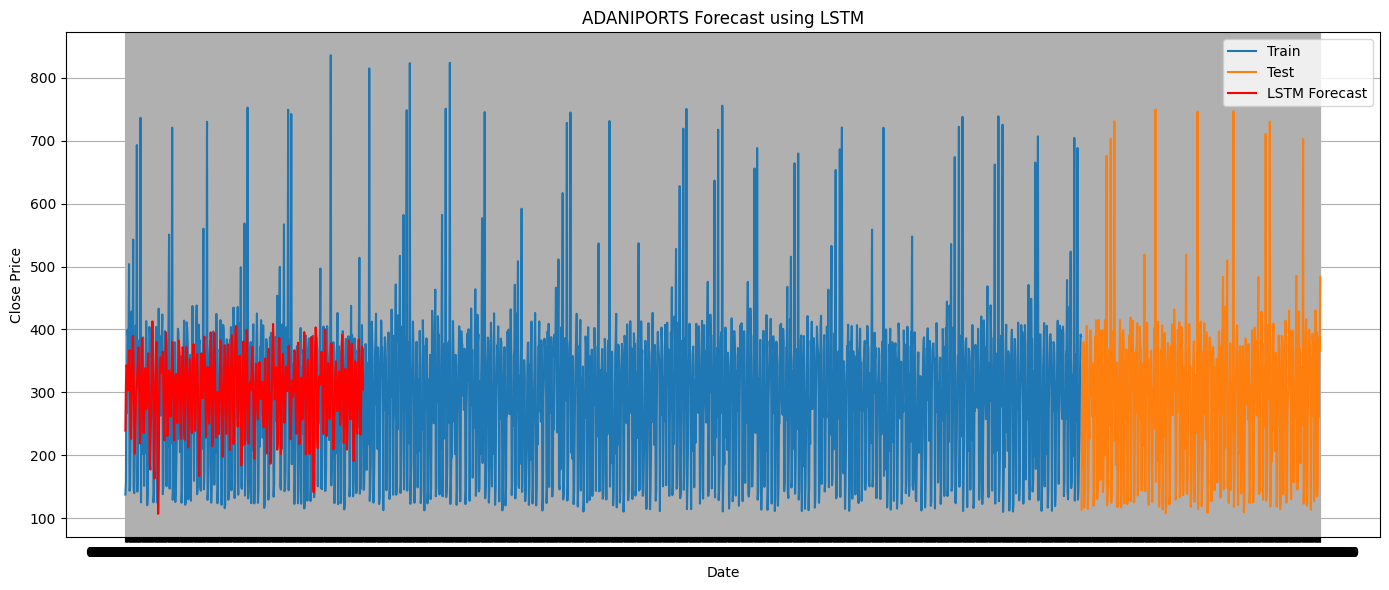

In [65]:
# Plot results
plt.figure(figsize=(14, 6))
plt.plot(df_symbol.index[:train_size], scaler.inverse_transform(scaled_data[:train_size]), label='Train')
plt.plot(df_symbol.index[train_size:], scaler.inverse_transform(scaled_data[train_size:]), label='Test')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='LSTM Forecast', color='red')
plt.title(f'{symbol} Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [66]:
## TCS
symbol = 'TCS'
df_symbol = df[df['Symbol'] == symbol].copy()
if 'Date' in df_symbol.columns:
    df_symbol.sort_values('Date', inplace=True)
    df_symbol.set_index('Date', inplace=True)
else:
    df_symbol.sort_index(inplace=True)

In [67]:
train_size = int(len(df_symbol) * 0.8)
train = df_symbol['Close'][:train_size]
test = df_symbol['Close'][train_size:]

In [68]:
# Prepare data for LSTM
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_symbol['Close'].values.reshape(-1, 1))

In [69]:
# Create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

In [70]:
# Split sequences into train and test
train_size_seq = int(len(X) * 0.8)
X_train, y_train = X[:train_size_seq], y[:train_size_seq]
X_test, y_test = X[train_size_seq:], y[train_size_seq:]

In [71]:
# Build LSTM model
model_3 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])
model_3.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
history = model_3.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0740 - val_loss: 0.0440
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0292 - val_loss: 0.0195
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0178 - val_loss: 0.0194
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0184 - val_loss: 0.0201
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0179 - val_loss: 0.0201
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0178 - val_loss: 0.0189
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0170 - val_loss: 0.0198
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0176 - val_loss: 0.0215
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0177 - val_loss: 0.0203
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0173 - val_loss: 0.0191
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0162 - val_loss: 0.0186
Epoch 12/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0

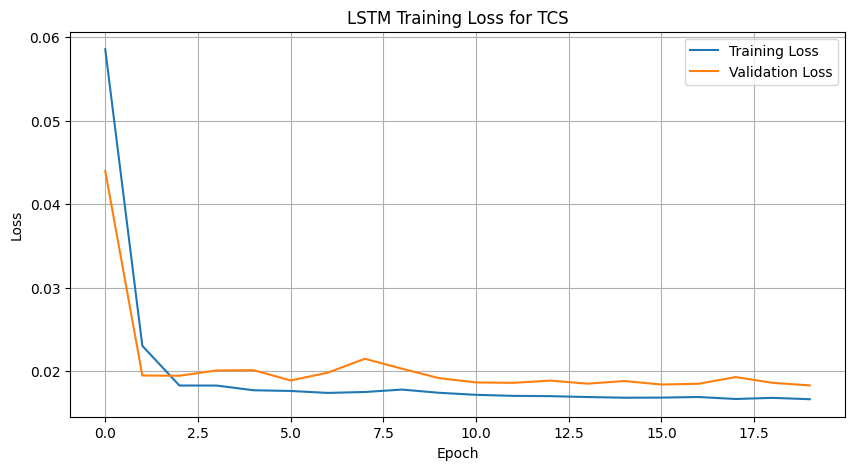

In [73]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'LSTM Training Loss for {symbol}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [74]:
# Forecast
predictions = model_3.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scale to original values
y_test = scaler.inverse_transform(y_test)  # Inverse scale test data

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [75]:
# Adjust for sequence length
forecast_df = pd.DataFrame({
        'Forecast': predictions.flatten(),
        'Actual': y_test.flatten()
})  # Align index with predictions

In [76]:
forecast_df.head()

,Forecast,Actual
0,1040.984009,1229.95
1,869.608459,631.35
2,723.151306,699.55
3,980.329834,1128.60
4,1607.196289,1220.80


In [77]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'LSTM RMSE for {symbol}: {rmse}')

LSTM RMSE for TCS: 412.1604474456279


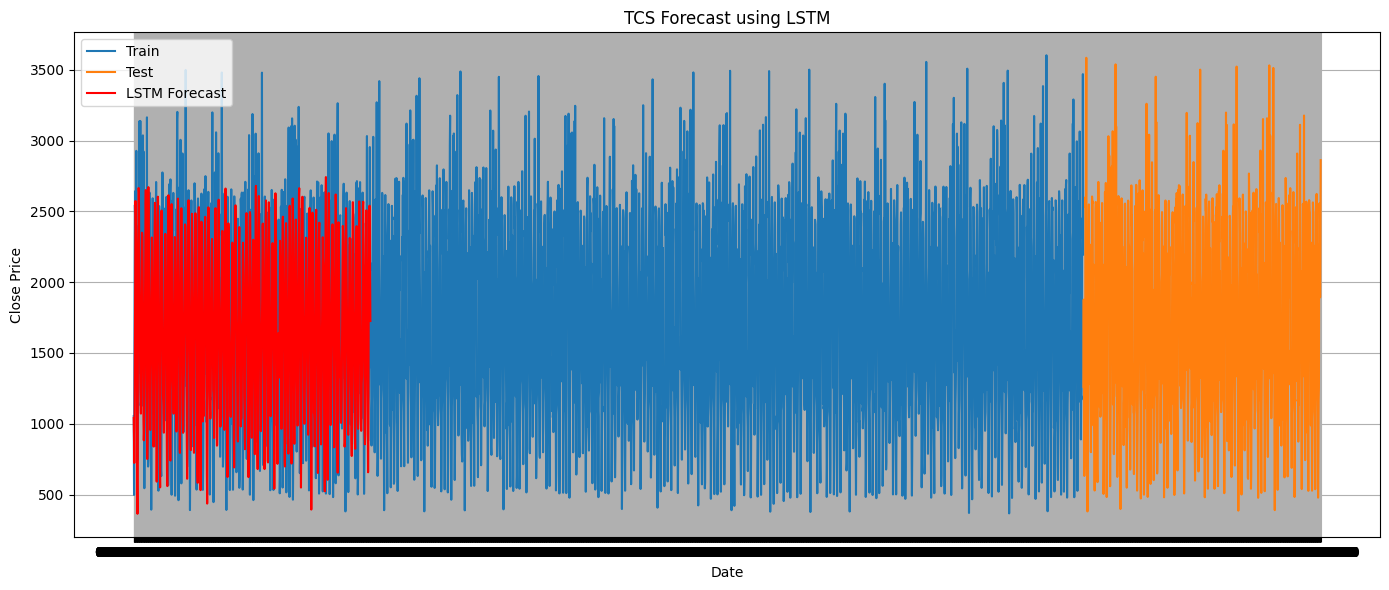

In [78]:
# Plot results
plt.figure(figsize=(14, 6))
plt.plot(df_symbol.index[:train_size], scaler.inverse_transform(scaled_data[:train_size]), label='Train')
plt.plot(df_symbol.index[train_size:], scaler.inverse_transform(scaled_data[train_size:]), label='Test')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='LSTM Forecast', color='red')
plt.title(f'{symbol} Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
## ULTRACEMCO
symbol = 'ULTRACEMCO'
df_symbol = df[df['Symbol'] == symbol].copy()
if 'Date' in df_symbol.columns:
    df_symbol.sort_values('Date', inplace=True)
    df_symbol.set_index('Date', inplace=True)
else:
    df_symbol.sort_index(inplace=True)

In [80]:
train_size = int(len(df_symbol) * 0.8)
train = df_symbol['Close'][:train_size]
test = df_symbol['Close'][train_size:]

In [81]:
# Prepare data for LSTM
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_symbol['Close'].values.reshape(-1, 1))

In [82]:
# Create sequences for LSTM
def create_sequences(data, seq_length=10):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Number of time steps to look back
X, y = create_sequences(scaled_data, seq_length)

In [83]:
# Split sequences into train and test
train_size_seq = int(len(X) * 0.8)
X_train, y_train = X[:train_size_seq], y[:train_size_seq]
X_test, y_test = X[train_size_seq:], y[train_size_seq:]

In [84]:
# Build LSTM model
model_4 = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    LSTM(50),
    Dense(25),
    Dense(1)
])
model_4.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [85]:
history = model_4.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0607 - val_loss: 0.0255
Epoch 2/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0260 - val_loss: 0.0274
Epoch 3/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0216 - val_loss: 0.0227
Epoch 4/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0212 - val_loss: 0.0209
Epoch 5/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0202 - val_loss: 0.0201
Epoch 6/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0184 - val_loss: 0.0253
Epoch 7/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 0.0191 - val_loss: 0.0200
Epoch 8/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0175 - val_loss: 0.0194
Epoch 9/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0182 - val_loss: 0.0193
Epoch 10/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0176 - val_loss: 0.0195
Epoch 11/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0178 - val_loss: 0.0193
Epoch 12/20
93/93 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0

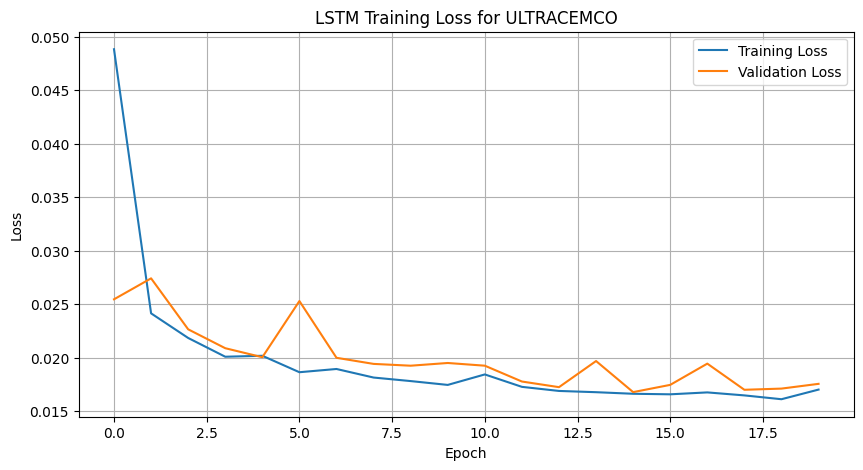

In [86]:
# Plot training history
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title(f'LSTM Training Loss for {symbol}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [87]:
# Forecast
predictions = model_4.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Inverse scale to original values
y_test = scaler.inverse_transform(y_test)  # Inverse scale test data

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


In [88]:
# Adjust for sequence length
forecast_df = pd.DataFrame({
        'Forecast': predictions.flatten(),
        'Actual': y_test.flatten()
})  # Align index with predictions

In [89]:
forecast_df.head()

,Forecast,Actual
0,623.597778,824.40
1,843.103210,674.95
2,1224.150024,924.65
3,1705.257690,1023.25
4,2201.115479,1384.00


In [90]:
# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'LSTM RMSE for {symbol}: {rmse}')

LSTM RMSE for ULTRACEMCO: 865.071587047942


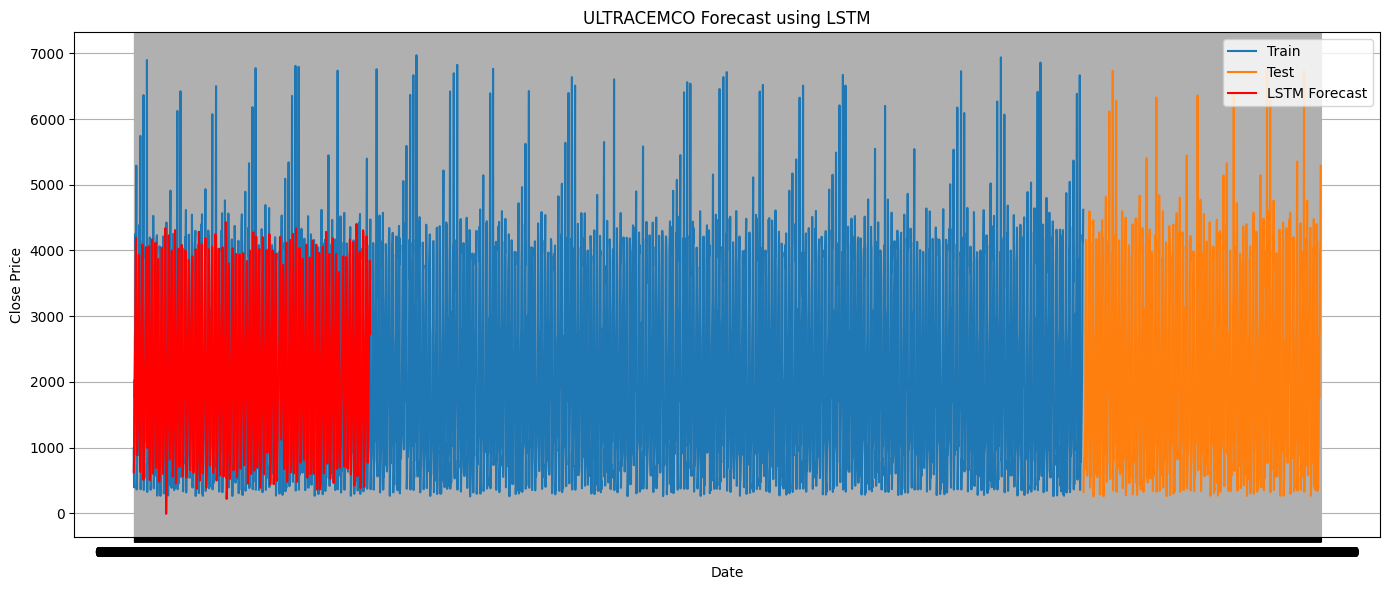

In [91]:
# Plot results
plt.figure(figsize=(14, 6))
plt.plot(df_symbol.index[:train_size], scaler.inverse_transform(scaled_data[:train_size]), label='Train')
plt.plot(df_symbol.index[train_size:], scaler.inverse_transform(scaled_data[train_size:]), label='Test')
plt.plot(forecast_df.index, forecast_df['Forecast'], label='LSTM Forecast', color='red')
plt.title(f'{symbol} Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()